In [40]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame

from math import sqrt
from numpy import concatenate
from pandas import concat
from numpy import ndarray

from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
case = pd.read_csv('data/new/case_maret_july.csv')

mobility = pd.read_csv('data/new/mobility_maret_july.csv')
weather = pd.read_csv('data/new/weather_maret_july.csv')
mobility.set_index('date', inplace=True)

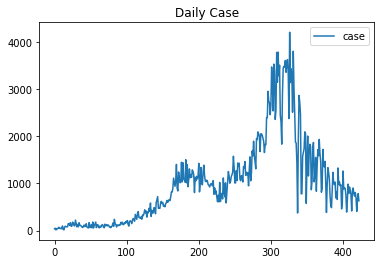

In [4]:
case.plot()
plt.title("Daily Case")
plt.show()

In [5]:
new_weather = weather.interpolate(method='spline', order=2)

new_date = weather[['date']]

new_weather.set_index('date', inplace=True)

In [6]:
case['date'] = case['date'].astype('datetime64[ns]')
case.set_index('date', inplace=True)
case.head()

,case
date,
2020-03-18,38
2020-03-19,50
2020-03-20,14
2020-03-21,44
2020-03-22,36


In [7]:
# Ambil data untuk evaluasi
data_evaluasi = case[413:]

In [8]:
decompose = seasonal_decompose(case, model='additive', extrapolate_trend='freq')

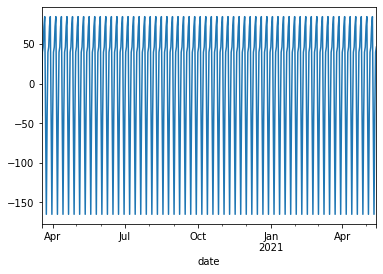

In [9]:
decompose.seasonal.plot()
plt.show()

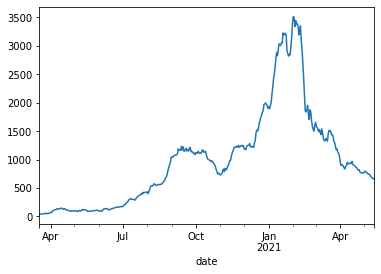

In [10]:
decompose.trend.plot()
plt.show()

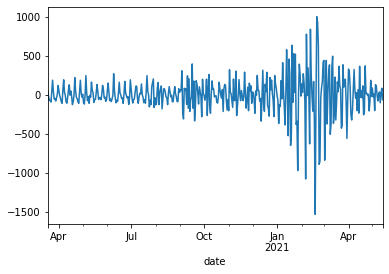

In [11]:
decompose.resid.plot()
plt.show()

In [12]:
trend = decompose.trend
seasonal = decompose.seasonal
residual = decompose.resid
actual = decompose.observed

In [13]:
new_trend = trend.to_frame()
new_seasonal = seasonal.to_frame()
new_residual = residual.to_frame()
new_actual = actual.to_frame()

In [14]:
# Split data ARIMA
train_ARIMA = new_trend[:412]
test_ARIMA = new_trend[412:]

In [15]:
model = ARIMA(train_ARIMA, order=(2,0,1))
model_fit = model.fit()

C:\ProgramData\Anaconda3\envs\Forecatsing\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\envs\Forecatsing\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\envs\Forecatsing\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [16]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  trend   No. Observations:                  412
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -2203.667
Date:                Tue, 14 Sep 2021   AIC                           4417.334
Time:                        12:41:08   BIC                           4437.439
Sample:                    03-18-2020   HQIC                          4425.287
                         - 05-03-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        997.2644    569.026      1.753      0.080    -118.006    2112.534
ar.L1          1.7395      0.034     51.455      0.000       1.673       1.806
ar.L2         -0.7420      0.034    -22.001      0.0

In [17]:
hasil = model_fit.forecast(10)

In [18]:
hasil.head()

2021-05-04    785.700668
2021-05-05    787.074250
2021-05-06    788.625656
2021-05-07    790.305075
2021-05-08    792.075229
Freq: D, Name: predicted_mean, dtype: float64

In [19]:
new_seasonal.reset_index(drop=True, inplace=True)
seasonal_data = pd.concat([new_date, new_seasonal], axis=1)
seasonal_data.set_index('date', inplace=True)

new_residual.reset_index(drop=True, inplace=True)
residual_data = pd.concat([new_date, new_residual], axis=1)
residual_data.set_index('date', inplace=True)

In [20]:
seasonal_data.head()

,seasonal
date,
2020-03-18,-40.116647
2020-03-19,39.596803
2020-03-20,46.139292
2020-03-21,71.891567
2020-03-22,84.486805


In [21]:
residual_data.head()

,resid
date,
2020-03-18,42.177871
2020-03-19,-27.596803
2020-03-20,-72.200516
2020-03-21,-71.320138
2020-03-22,-93.058233


In [22]:
data_seasonal = pd.concat([seasonal_data, new_weather, mobility], axis=1)

data_residual = pd.concat([residual_data, new_weather, mobility], axis=1)

In [23]:
# frame as supervised learning
reframed_seasonal = series_to_supervised(data_seasonal, 1, 1)
reframed_residual = series_to_supervised(data_residual, 1, 1)

In [24]:
# drop columns we don't want to predict
reframed_seasonal.drop(reframed_seasonal.columns[[12,13,14,15,16,17,18,19,20,21]], axis=1, inplace=True)
reframed_residual.drop(reframed_residual.columns[[12,13,14,15,16,17,18,19,20,21]], axis=1, inplace=True)

In [25]:
# split into train and test sets
values_seasonal= reframed_seasonal.values
values_residual= reframed_residual.values

#n_total = round((values.shape[0])*80/100)
n_total = 412


train_seasonal = values_seasonal[:n_total, :]
test_seasonal = values_seasonal[n_total:, :]

train_residual = values_residual[:n_total, :]
test_residual = values_residual[n_total:, :]

# split into input and outputs
seasonal_train_X, seasonal_train_y = train_seasonal[:, :-1], train_seasonal[:, -1]
seasonal_test_X, seasonal_test_y = test_seasonal[:, :-1], test_seasonal[:, -1]

residual_train_X, residual_train_y = train_residual[:, :-1], train_residual[:, -1]
residual_test_X, residual_test_y = test_residual[:, :-1], test_residual[:, -1]

# reshape input to be 3D [samples, timesteps, features]
seasonal_train_X = seasonal_train_X.reshape((seasonal_train_X.shape[0], 1, seasonal_train_X.shape[1]))
seasonal_test_X = seasonal_test_X.reshape((seasonal_test_X.shape[0], 1, seasonal_test_X.shape[1]))

residual_train_X = residual_train_X.reshape((residual_train_X.shape[0], 1, residual_train_X.shape[1]))
residual_test_X = residual_test_X.reshape((residual_test_X.shape[0], 1, residual_test_X.shape[1]))


#print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


Epoch 1/100
83/83 - 2s - loss: 68.7472 - val_loss: 59.8253
Epoch 2/100
83/83 - 0s - loss: 68.0201 - val_loss: 59.1537
Epoch 3/100
83/83 - 0s - loss: 67.4282 - val_loss: 58.5061
Epoch 4/100
83/83 - 0s - loss: 66.7781 - val_loss: 57.6547
Epoch 5/100
83/83 - 0s - loss: 66.0213 - val_loss: 56.9861
Epoch 6/100
83/83 - 0s - loss: 65.4149 - val_loss: 56.3580
Epoch 7/100
83/83 - 0s - loss: 64.7793 - val_loss: 55.6843
Epoch 8/100
83/83 - 0s - loss: 64.1646 - val_loss: 55.0111
Epoch 9/100
83/83 - 0s - loss: 63.4950 - val_loss: 54.5104
Epoch 10/100
83/83 - 0s - loss: 62.8263 - val_loss: 53.8718
Epoch 11/100
83/83 - 0s - loss: 62.2318 - val_loss: 53.2730
Epoch 12/100
83/83 - 0s - loss: 61.5449 - val_loss: 52.7198
Epoch 13/100
83/83 - 0s - loss: 60.8003 - val_loss: 52.1667
Epoch 14/100
83/83 - 0s - loss: 60.1359 - val_loss: 51.5689
Epoch 15/100
83/83 - 0s - loss: 59.4787 - val_loss: 50.9918
Epoch 16/100
83/83 - 0s - loss: 58.8339 - val_loss: 50.4713
Epoch 17/100
83/83 - 0s - loss: 58.1305 - val_los

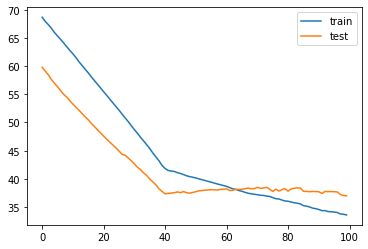

In [26]:
# LSTM model untuk seasonal
model1 = Sequential()
model1.add(LSTM(50, input_shape=(seasonal_train_X.shape[1], seasonal_train_X.shape[2])))
model1.add(Dense(1))
model1.compile(loss='mae', optimizer='adam')
# fit network
history = model1.fit(seasonal_train_X, seasonal_train_y, epochs=100, batch_size=5, validation_data=(seasonal_test_X, seasonal_test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [27]:
# make a prediction
yhat_seasonality = model1.predict(seasonal_test_X)
yhat_seasonality

array([[-4.0100739e+01],
       [ 3.4631133e+00],
       [ 5.0864208e+01],
       [ 6.8790077e+01],
       [ 7.4515755e+01],
       [ 6.8610641e+01],
       [-1.2353897e-02],
       [-4.0094891e+01],
       [ 2.0824912e+00],
       [ 5.3262119e+01]], dtype=float32)

Epoch 1/100
83/83 - 1s - loss: 151.7433 - val_loss: 64.8104
Epoch 2/100
83/83 - 0s - loss: 151.6497 - val_loss: 64.9596
Epoch 3/100
83/83 - 0s - loss: 151.5842 - val_loss: 64.9421
Epoch 4/100
83/83 - 0s - loss: 151.5638 - val_loss: 65.0900
Epoch 5/100
83/83 - 0s - loss: 151.5101 - val_loss: 65.1915
Epoch 6/100
83/83 - 0s - loss: 151.4560 - val_loss: 65.3167
Epoch 7/100
83/83 - 0s - loss: 151.4098 - val_loss: 65.4059
Epoch 8/100
83/83 - 0s - loss: 151.3625 - val_loss: 65.5222
Epoch 9/100
83/83 - 0s - loss: 151.3139 - val_loss: 65.5976
Epoch 10/100
83/83 - 0s - loss: 151.2713 - val_loss: 65.6644
Epoch 11/100
83/83 - 0s - loss: 151.2124 - val_loss: 65.7913
Epoch 12/100
83/83 - 0s - loss: 151.1635 - val_loss: 65.9306
Epoch 13/100
83/83 - 0s - loss: 151.0943 - val_loss: 65.8749
Epoch 14/100
83/83 - 0s - loss: 151.0547 - val_loss: 65.9382
Epoch 15/100
83/83 - 0s - loss: 150.9876 - val_loss: 66.1215
Epoch 16/100
83/83 - 0s - loss: 150.9252 - val_loss: 66.1924
Epoch 17/100
83/83 - 0s - loss: 1

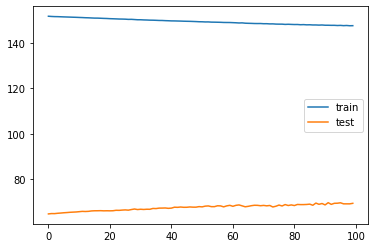

In [28]:
# LSTM model untuk residual
model2 = Sequential()
model2.add(LSTM(50, input_shape=(residual_train_X.shape[1], residual_train_X.shape[2])))
model2.add(Dense(1))
model2.compile(loss='mae', optimizer='adam')
# fit network
history = model2.fit(residual_train_X, residual_train_y, epochs=100, batch_size=5, validation_data=(residual_test_X, residual_test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [29]:
# make a prediction
yhat_residual = model2.predict(residual_test_X)
yhat_residual

array([[ -0.721514],
       [ 27.678627],
       [ 27.381794],
       [-17.55874 ],
       [-17.247551],
       [  2.137965],
       [ 18.79297 ],
       [-17.31351 ],
       [ -9.548098],
       [  4.477814]], dtype=float32)

In [30]:
data_evaluasi

,case
date,
2021-05-04,416
2021-05-05,845
2021-05-06,905
2021-05-07,783
2021-05-08,732
2021-05-09,809
2021-05-10,694
2021-05-11,406
2021-05-12,656


In [42]:
#type(yhat_residual)


#embuh = ndarray.tolist(yhat_residual)
#embuh

residual_test_X = residual_test_X.reshape((residual_test_X.shape[0], residual_test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat_residual, residual_test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

NameError: name 'scaler' is not defined

In [35]:
#list_hasil = hasil['case'].tolist()
list_evaluasi = data_evaluasi['case'].tolist()

In [36]:
list_evaluasi

[416, 845, 905, 783, 732, 809, 694, 406, 656, 785, 632]

In [37]:
length = len(list_evaluasi)

for i in range(length):
    print('hasil evaluasi',list_evaluasi[i])
    print('hasil residual',hasil_residual[i])

hasil evaluasi 416
hasil residual [-0.7215139865875244]
hasil evaluasi 845
hasil residual [27.678627014160156]
hasil evaluasi 905
hasil residual [27.381793975830078]
hasil evaluasi 783
hasil residual [-17.558740615844727]
hasil evaluasi 732
hasil residual [-17.24755096435547]
hasil evaluasi 809
hasil residual [2.137964963912964]
hasil evaluasi 694
hasil residual [18.792970657348633]
hasil evaluasi 406
hasil residual [-17.31351089477539]
hasil evaluasi 656
hasil residual [-9.548097610473633]
hasil evaluasi 785
hasil residual [4.477814197540283]
hasil evaluasi 632


IndexError: list index out of range